In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
%matplotlib inline 

def kmeansrnd(n, d, k):
    s = 10
    m = np.random.randn(k, d)
    X = np.random.randn(n, d)
    w = np.random.dirichlet(np.ones(k), 1)
    z = np.random.multinomial(1, w[0], n)
    X += s * z @ m
    return (X, np.argmax(z, 1))

def plot_class(X, y):
    color = 'brgmcyk';
    for k in np.unique(y):
        idx = y==k
        plt.scatter(X[idx,0], X[idx,1],c=color[k])

In [15]:
class Gauss :
    def __init__(self, d):
        self.m = np.zeros(d)
        self.C = np.eye(d)

    def fit(self, X, r, a = 1e-6):
        (n,d) = X.shape
        nk = sum(r)
        m = r@X/nk
        Xo = (X-m)*np.sqrt(r).reshape(n,1)
        C = (Xo.T @ Xo)/nk+a*np.eye(d)
        self.m = m
        self.C = C

    def logpdf(self, X):
        g = multivariate_normal(self.m, self.C)
        return g.logpdf(X)

def e_step(X, R, w, coms):
    n = len(X)
    for k in range(len(coms)):
        R[:,k] = coms[k].logpdf(X)
    R = R+np.log(w)
    T = logsumexp(R,1)
    llh = sum(T)/n 
    R = np.exp(R-T.reshape(n,1))
    return (R, llh) 

def m_step(X, R, coms):
    (n,d) = X.shape
    k = R.shape[1]
    w = np.mean(R,0)
    for j in range(len(coms)):
        coms[j].fit(X,R[:,j])
    return (w,coms)

def emgm(X, k) :
    (n,d) = X.shape
    tol = 1e-4
    epoch = 200
    llh = np.full(epoch+1, -np.inf)
    label = np.random.randint(k,size=n)
    R = np.arange(k).reshape(1,k) == label.reshape(n,1)
    R = R.astype(float)
    coms = [Gauss(d) for i in range(k)]
    for t in range(epoch):
        (w,coms) = m_step(X, R, coms)
        (R, llh[t+1]) = e_step(X, R, w, coms)
        if llh[t+1]-llh[t] < tol : break
    label = np.argmax(R,1)
    return (label, llh[1:t+1])

In [16]:
def ol_gs_dp(X, alpha, theta):
    # online Gibbs Sampling Dirchlet Process Gaussian Mixture
    coms = [theta]
    nk = [alpha]
    for x in X:
        p = [nk[k]+coms[k].logmpdf(x) for k in len(coms)]
        p = np.exp(p-logsumexp(p))
        z = np.random.multinomial(1, p, n)
        k = np.argmax(z)
        coms[k].add_sample(x)
        nk[k] += 1
        if k == len(coms):
            coms.append(theta)
            nk.append(alpha)

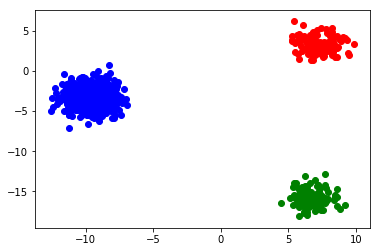

In [17]:
n = 1000
d = 2
k = 3

(X,z) = kmeansrnd(n,d,k)
# label = np.random.randint(k,size=n)
(label,llh)=emgm(X,k)
plot_class(X,label)

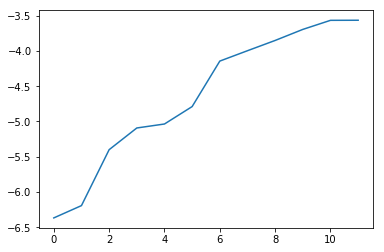

In [18]:
plt.plot(llh)